**Used Google Collab for GPU acceleration in order for faster performance.**

In [1]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch import nn
import matplotlib
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader


In [2]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

Using device cuda


# **Training CIFAR-10 Dataset**

In [3]:
transform = torchvision.transforms.ToTensor()
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
train_size = int(len(training_data) * 0.8) # 80% training data
valid_size = len(training_data) - train_size # 20% validation data
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, valid_size])
train_loader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size=64, shuffle=True)


100%|██████████| 170498071/170498071 [00:13<00:00, 13036203.91it/s]


Extracting data/cifar-10-python.tar.gz to data


In [4]:
#Citation for code chunks: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

batch_size = 128
transform = torchvision.transforms.ToTensor()
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform_train,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_size = int(len(training_data) * 0.8) # 80% training data
valid_size = len(training_data) - train_size # 20% validation data
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, valid_size])
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        #performs max pooling on the input data --> reduces size of feature maps
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.relu6 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512*4*4, 1024)
        self.relu7 = nn.ReLU()
        #dropout prevents overfitting
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(1024, 512)
        self.relu8 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(512, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.conv6(x)
        x = self.relu6(x)
        x = self.pool3(x)
        x = x.view(-1, 512*16)
        x = self.fc1(x)
        x = self.relu7(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu8(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv_layers = nn.Sequential(
#             nn.Conv2d(3, 32, kernel_size=3, padding=1),
#             nn.BatchNorm2d(32),
#             _size=3, padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#         )
#         self.fc_layers = nn.Sequential(
#             nn.Linear(128*8*8, 512),
#             nn.BatchNorm1d(512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, 10),
#         )

#     def forward(self, x):
#         x = self.conv_layers(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc_layers(x)
#         return x

model = CNN().to(device)
print(model)
print(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

epochs = 15
training_acc = []
training_loss = []
validation_acc = []
validation_loss = []
for epoch in np.arange(epochs):
    print(f"\nEpoch {epoch+1}\n-------------------------------")
    size = len(train_dataloader.dataset)
    num_batches = len(train_dataloader)
    train_loss, other_correct = 0, 0
    model.train()
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        other_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        train_loss += loss_fn(pred, y).item()
        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
    train_loss /= num_batches
    other_correct /= size
    training_acc.append(100*other_correct)
    training_loss.append(train_loss)
    print("Training Accuracy: ", (100*other_correct))
    scheduler.step()
    # size = len(validation_dataloader.dataset)
    # num_batches = len(validation_dataloader)
    # model.eval()
    # val_loss, correct = 0, 0
    # with torch.no_grad():
    #     for X, y in validation_dataloader:
    #         X, y = X.to(device), y.to(device)
    #         pred = model(X)
    #         val_loss += loss_fn(pred, y).item()
    #         correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # val_loss /= num_batches
    # correct /= size
    # validation_acc.append(100*correct)
    # validation_loss.append(val_loss)
    # print("Validation Accuracy: ", (100*correct))
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for X, y in validation_dataloader:
        X, y = X.float().to(device), y.float().to(device)
        pred = model(X)
        num_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    print("\nFinal Validation Accuracy:", num_correct / len(validation_dataloader.dataset))
    model.train() # Put model back in train mode
# print('Training Accuracy: ', training_acc)
# print('Validation Accuracy: ', validation_acc)
# print('Training Loss: ', training_loss)
# print('Validation Loss: ', validation_loss)


Files already downloaded and verified
CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU()
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu6): ReLU()
  (pool3): MaxPool2d(kernel

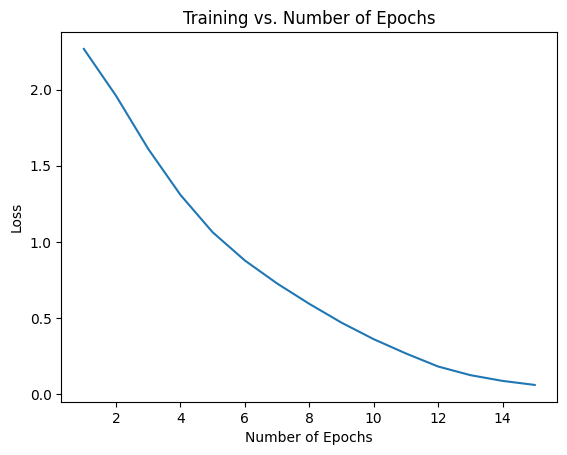

In [5]:
plt.plot(np.arange(1, 16), training_loss)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Number of Epochs')
plt.show()

In [7]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):

    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("data/cifar10_test_data_sp23.npy"), "You must upload the test data to the file system."
        self.data = [np.load("data/cifar10_test_data_sp23.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform_train
)
print(len(testing_data))

10000


In [8]:
batch_size = 128
test_dataloader = torch.utils.data.DataLoader(testing_data, shuffle=False)
print(len(test_dataloader))
model.eval()
predictions = []
with torch.no_grad():
    for x in test_dataloader:
        outputs = model(x.to(device))
        # convert outputs to probabilities and get the class with highest probability
        probabilities, predicted_classes = torch.max(torch.softmax(outputs, dim=1), dim=1)
        predictions.append(predicted_classes.cpu().numpy()[0])
print(predictions)
print(type(predictions))

10000
[0, 8, 8, 3, 3, 3, 0, 8, 3, 7, 2, 5, 5, 1, 3, 7, 2, 7, 5, 4, 2, 1, 4, 5, 0, 8, 8, 5, 8, 3, 8, 3, 8, 4, 8, 2, 7, 0, 0, 7, 2, 7, 2, 0, 1, 7, 5, 0, 9, 1, 6, 6, 3, 3, 4, 3, 0, 0, 9, 8, 6, 3, 5, 3, 5, 3, 8, 9, 7, 3, 7, 2, 9, 3, 3, 7, 8, 3, 5, 6, 1, 1, 7, 3, 2, 0, 0, 9, 8, 5, 5, 6, 1, 8, 6, 2, 9, 6, 5, 3, 6, 3, 6, 3, 3, 1, 3, 6, 9, 8, 1, 3, 4, 2, 1, 1, 8, 9, 7, 2, 1, 8, 2, 6, 8, 6, 3, 7, 8, 6, 8, 6, 6, 7, 5, 8, 8, 5, 0, 3, 1, 6, 8, 8, 6, 2, 6, 0, 4, 6, 3, 2, 2, 1, 9, 8, 0, 1, 4, 2, 6, 2, 1, 4, 8, 1, 1, 9, 6, 1, 0, 0, 8, 6, 1, 2, 2, 6, 2, 8, 9, 5, 2, 7, 5, 6, 6, 5, 4, 3, 8, 8, 1, 2, 2, 6, 1, 3, 6, 8, 1, 2, 7, 1, 2, 1, 3, 1, 2, 1, 7, 2, 9, 6, 3, 4, 2, 3, 1, 5, 9, 6, 3, 1, 7, 0, 8, 1, 2, 7, 7, 5, 5, 3, 3, 7, 0, 6, 1, 1, 3, 1, 7, 4, 8, 8, 8, 9, 1, 8, 7, 8, 0, 8, 7, 0, 5, 9, 3, 1, 5, 7, 5, 0, 3, 8, 4, 1, 8, 3, 7, 1, 3, 6, 2, 8, 3, 1, 7, 2, 5, 9, 9, 2, 9, 7, 6, 2, 0, 2, 2, 3, 0, 6, 5, 5, 3, 0, 3, 6, 8, 7, 6, 5, 2, 3, 9, 8, 6, 1, 1, 0, 2, 2, 7, 3, 7, 6, 4, 3, 5, 8, 2, 6, 6, 9, 9, 0, 6, 3, 7, 

In [9]:
# This code below will generate kaggle_predictions.csv file.
import pandas as pd
if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
print(predictions.shape)
print(len(testing_data))
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1.
df.to_csv('submission.csv', index_label='Id')

(10000,)
10000


# **Kaggle Prediction Accuracy: 78.6%**